In [526]:
import string
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import f1_score

import time
%matplotlib inline

In [527]:
train = pd.read_csv('./Data/train_set.csv')
validation = pd.read_csv('./Data/validation_set.csv')
test = pd.read_csv('./Data/test_set.csv')

In [528]:
train = train.dropna(axis = 0)
tweets_train = train['filtered_tweet'].dropna(axis = 0)

validation = validation.dropna(axis = 0)
tweets_val = validation['filtered_tweet'].dropna(axis = 0)

test = test.dropna(axis = 0)
tweets_test = test['filtered_tweet'].dropna(axis = 0)

In [529]:
# trial 1: combine tow classifiers using linear regression

In [530]:
tfidf_vectorizer_train = TfidfVectorizer(use_idf=True, max_features=3000)
tfidf_vec_train = tfidf_vectorizer_train.fit_transform(tweets_train)

tfidf_vectorizer_val = TfidfVectorizer(use_idf=True, max_features=3000)
tfidf_vec_val = tfidf_vectorizer_val.fit_transform(tweets_val)

tfidf_vectorizer_test = TfidfVectorizer(use_idf=True, max_features=3000)
tfidf_vec_test = tfidf_vectorizer_test.fit_transform(tweets_test)

In [531]:
tfidf_vec_train.shape, tfidf_vec_val.shape, tfidf_vec_test.shape

((106693, 3000), (26671, 3000), (14820, 3000))

In [532]:
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier, LinearRegression
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

In [533]:
# train on tfidf

y_train = train['label']
X_train1 = tfidf_vec_train
X_train2 = train[['polarity','subjectivity','word_count']]

y_val = validation['label']
X_val1 = tfidf_vec_val
X_val2 = validation[['polarity','subjectivity','word_count']]

# Training
start1 = time.time()

classifier_tfidf = XGBClassifier(n_estimators = 100,learning_rate = 0.10)
classifier_tfidf.fit(X_train1, y_train)


classifier_2 = XGBClassifier(n_estimators = 100,learning_rate = 0.10)
classifier_2.fit(X_train2, y_train)

end1 = time.time()

print('laryer 1 training time:', end1-start1)
c1_prob_train = classifier_tfidf.predict_proba(X_train1)
c1_prob_val = classifier_tfidf.predict_proba(X_val1)

c2_prob_train = classifier_2.predict_proba(X_train2)
c2_prob_val = classifier_2.predict_proba(X_val2)

y1_pred_train = classifier_tfidf.predict(X_train1)
y1_pred_val = classifier_tfidf.predict(X_val1)


y2_pred_train = classifier_2.predict(X_train2)
y2_pred_val = classifier_2.predict(X_val2)

#combie in validation set

laryer 1 training time: 152.7650489807129


In [534]:
y_test = test['label']
X_test1 = tfidf_vec_test
X_test2 = test[['polarity','subjectivity','word_count']]

In [535]:
# fit first layer

y1_pred_test = classifier_tfidf.predict(X_test1)
y2_pred_test = classifier_2.predict(X_test2)

c1_prob_test = classifier_tfidf.predict_proba(X_test1)
c2_prob_test = classifier_2.predict_proba(X_test2)

In [536]:
# train sumclassifier
# using predicted probability list 
# fit by train predicted probability list

In [537]:
y_train_prob = []
for i in range(len(y_train)):
    sublist = [0]*15
    map = {0:0,1:1,2:2,3:3,4:4,5:5,7:6,8:7,11:8,13:9,14:10,15:11,16:12,17:13,19:14}
    key = map[y_train[i]]
    sublist[key] = 1
    y_train_prob.append(sublist)  
y_train_prob = np.array(y_train_prob)

In [538]:
# coef_list_train = []
start2 = time.time()
p_label_list = []
for e in range(15):
    label = y_train_prob[:, e]

    model_prob1 = c1_prob_train[:, e]
    model_prob2 = c2_prob_train[:, e]
    
    model_prob1_test = c1_prob_test[:, e]
    model_prob2_test = c2_prob_test[:, e]

    X_prob = pd.DataFrame([model_prob1, model_prob2]).values.reshape(-1,2)
    X_prob_test = pd.DataFrame([model_prob1_test, model_prob2_test]).values.reshape(-1,2)
    
#     X_prob = pd.DataFrame({'c1': model_prob1, 'c2': model_prob2})
#     X_prob_test = pd.DataFrame({'c1': model_prob1_test, 'c2': model_prob2_test})
    
    sum_classifier = LinearRegression()
    sum_classifier.fit(X_prob, label)

    p_label = sum_classifier.predict(X_prob_test)

    p_label_list.append(p_label) 

end2 = time.time()
print('layer 2 training time:', end2-start2)

pred_prob = np.array(p_label_list).transpose()


# pred_prob
#     coef_list_train.append([sum_classifier.intercept_, sum_classifier.coef_])
# coef_list_train

layer 2 training time: 75.63980221748352


In [539]:
map2 = {0:0,1:1,2:2,3:3,4:4,5:5,6:7,7:8,8:11,9:13,10:14,11:15,12:16,13:17,14:19}
y_pred = []
for i in range(len(pred_prob)):
    for j in range(len(pred_prob[i])):
        if pred_prob[i][j]==pred_prob[i].max():
            y_pred.append(map2[j])
y_pred = np.array(y_pred)

In [540]:
def multiclass_AUC_plot(y_pred, y_true, plot_name, classes = [0, 1, 2, 3, 4, 5, 7, 8, 11, 13, 14, 15, 16, 17, 19]):
    '''
    Plot for AUC curves
    :param y_true:
    :param y_pred:
    :param classes:
    :return:
    '''
    plt.figure(figsize=(8,4))
    y_true = label_binarize(y_true, classes)
    y_pred = label_binarize(y_pred, classes)

    n_classes = len(classes)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    # Plot all ROC curves
    plt.figure(figsize=(12,10))
    lw = 1
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_name)
    plt.legend(loc="lower right")
    plt.grid()
    plt.savefig(plot_name)
    plt.show()    

In [541]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from scipy import interp
from itertools import cycle

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Macro f1 score 0.0379
Micro f1 score 0.3974


<Figure size 576x288 with 0 Axes>

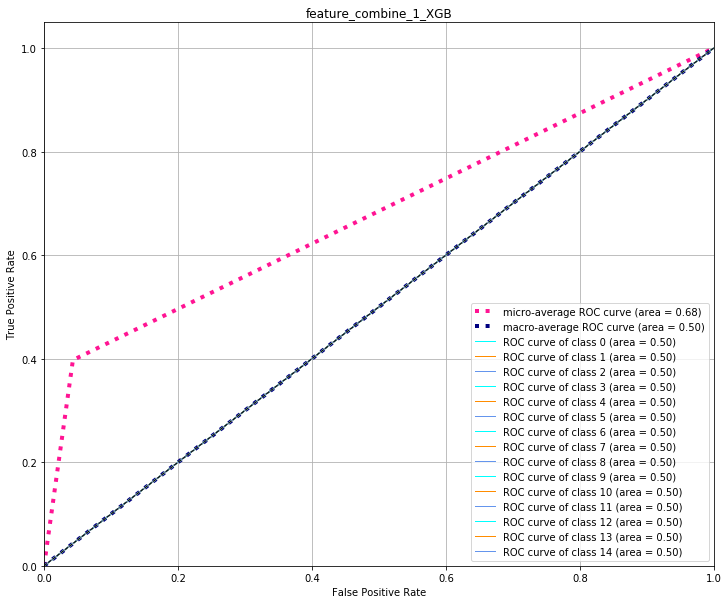

In [543]:
print('Macro f1 score %.4f' % f1_score(y_test, y_pred, average ='macro'))
print('Micro f1 score %.4f' % f1_score(y_test, y_pred, average ='micro'))
multiclass_AUC_plot(y_pred, y_test, plot_name='feature_combine_1_XGB')

In [544]:
# trial 2: pipeline feature union

In [545]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer

# from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, auc, roc_curve

#Visualization
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [546]:
y_train = train['label']
X_train = train[['filtered_tweet','polarity','subjectivity','word_count']]
y_val = validation['label']
X_val = validation[['filtered_tweet','polarity','subjectivity','word_count']]
y_test = test['label']
X_test = test[['filtered_tweet','polarity','subjectivity','word_count']]

In [547]:
# calculate recall at specific k 
def recall_at_k(y_pred, y_true, k):
    ct = 0
    for i in range(len(y_true)):
        if y_true[i] in y_pred[i][0:k]:
            ct += 1
    return ct/len(y_true)

In [548]:
"""Metrics to compute the model performance."""

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer
    
def dcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
#         print(actual)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

In [549]:
class ColumnExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, column_name):
        self.column_name = column_name
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.column_name]


class TextStats(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):
        return self

    def transform(self, col):
        return [{'value': i,} for i in col]

In [550]:
classifier_XGB = Pipeline([
    ('features', FeatureUnion([
        ('text_bow', Pipeline([
            ('selectcol', ColumnExtractor('filtered_tweet')),
            ('tfidf', TfidfVectorizer()),
#             ('svd', TruncatedSVD(n_components=100)), 
        ])),
        ('polarity', Pipeline([
            ('selectcol', ColumnExtractor('polarity')), 
            ('stats', TextStats()),
            ('vec', DictVectorizer()),
        ])),
        ('subjectivity', Pipeline([
            ('selectcol', ColumnExtractor('subjectivity')), 
            ('stats', TextStats()),
            ('vec', DictVectorizer()),
        ])),
        ('textlength', Pipeline([
            ('selectcol', ColumnExtractor('word_count')), 
            ('stats', TextStats()),
            ('vec', DictVectorizer()),
        ])),
    ])),
    ('clf', XGBClassifier()),
])

In [551]:
start = time.time()
classifier_XGB.fit(X_train, y_train)
end = time.time()
print('pipeline feture union XGB trainning time:', end-start)

pipeline feture union XGB trainning time: 598.5457258224487


In [552]:
pred_XGB = classifier_XGB.predict(X_test)
pred_proba_XGB = classifier_XGB.predict_proba(X_test)

Macro f1 score 0.1572
Micro f1 score 0.4509


<Figure size 576x288 with 0 Axes>

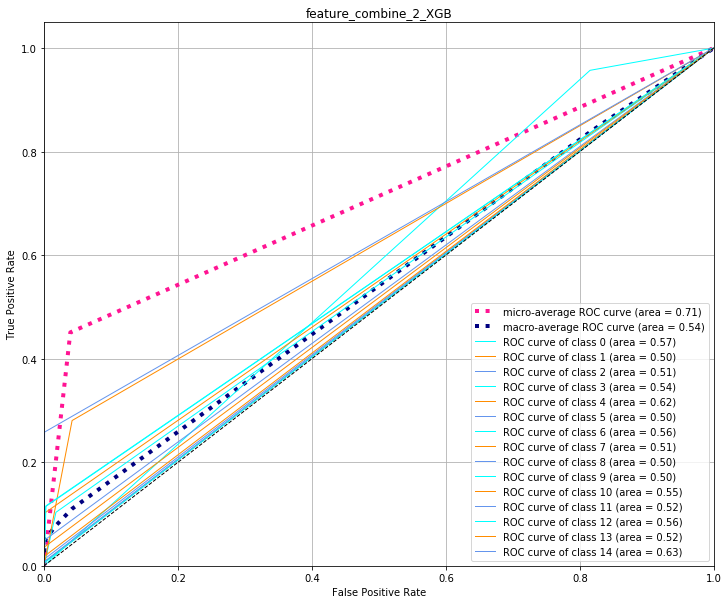

In [553]:
print('Macro f1 score %.4f' % f1_score(y_test, pred_XGB, average ='macro'))
print('Micro f1 score %.4f' % f1_score(y_test, pred_XGB, average ='micro'))
multiclass_AUC_plot(pred_XGB, y_test, plot_name='feature_combine_2_XGB')

In [554]:
print(ndcg_score(y_test, pred_proba_XGB, k=3))

0.6071478154149857


In [555]:
ranks, acc_rank = [], []
map2 = {0:0,1:1,2:2,3:3,4:4,5:5,6:7,7:8,8:11,9:13,10:14,11:15,12:16,13:17,14:19}
for i in range(pred_proba_XGB.shape[0]):
    temp = []
    for j in np.argsort(pred_proba_XGB[i][::-1]):
        temp.append(map2[j])
    ranks.append(temp)
for i in range(1, 16):
    acc_rank.append(recall_at_k(ranks, y_test, i))
print(acc_rank)

[0.31140350877192985, 0.43286099865047234, 0.5458839406207827, 0.6504048582995952, 0.7087719298245614, 0.8037112010796221, 0.8387314439946019, 0.8717273954116059, 0.8951417004048583, 0.9182860998650473, 0.9435897435897436, 0.9605937921727395, 0.9760458839406208, 0.9908906882591093, 1.0]


In [223]:
# prob_val = pd.DataFrame()
# prob1_val = []
# prob2_val = []
# for i in range(c1_prob_val.shape[0]):
#     prob1_val.append(c1_prob_val[i])
#     prob2_val.append(c2_prob_val[i])
# prob_val['classifier_tfidf'] = prob1_val
# prob_val['classifier_otherfeatures'] = prob2_val

In [224]:
# y_val_prob = []
# for i in range(len(y_val)):
#     sublist = [0]*15
#     map = {0:0,1:1,2:2,3:3,4:4,5:5,7:6,8:7,11:8,13:9,14:10,15:11,16:12,17:13,19:14}
#     key = map[y_val[i]]
#     sublist[key] = 1
#     y_val_prob.append(sublist) 

# y_val_prob = np.array(y_val_prob)
# prob1_val = np.array(prob1_val)
# prob2_val = np.array(prob2_val)

# prob_val['proba_label'] = y_val_prob
# prob_val.head()

In [225]:
# # compute emoji coef seperately
# emoji_index = 0
# coef_list = []
# for e in range(15):
#     label = y_val_proba_list[e]

#     model_prob1 = []
#     model_prob2 = []
#     for i in range(len(prob1)):
#         model_prob1.append(prob1[i][e])
#         model_prob2.append(prob2[i][e])
    
#     data = pd.DataFrame([model_prob1, model_prob2]).values.reshape(-1,2)
#     sum_classifier = LinearRegression()
#     coef_list.append([sum_classifier.fit(data, label).intercept_, sum_classifier.fit(data, label).coef_])
    